# Realistic set-up

In [1]:
from oggm import cfg
from oggm import tasks, utils, workflow, graphics
from oggm.core import massbalance
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import warnings
# Some annoying warnings sometimes
warnings.filterwarnings(action='ignore', category=UserWarning)

## Pick a glacier 

In [3]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

# Local working directory (where OGGM will write its output)
cfg.PATHS['working_dir'] = utils.mkdir('avalanche_dir')

2024-01-18 17:00:02: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-01-18 17:00:02: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-01-18 17:00:02: oggm.cfg: Multiprocessing: using all available processors (N=8)


In [4]:
rgi_ids = ['RGI60-11.01450']  # This is Aletsch
rgi_ids = ['RGI60-11.00897']  # This is Hintereisferner
rgi_ids = ['RGI60-11.03466']  # This is Talefre 
rgi_ids = ['RGI60-11.03638']  # This is Argentiere

# This is the url with loads of data (dhdt, velocities, etc)
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/'

# Can be replaced with 
# https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5 
# for smaller data

# This gets the data for this glacier - download can be a bit long because of all the data
gdir = workflow.init_glacier_directories(rgi_ids, prepro_base_url=base_url, from_prepro_level=3, prepro_border=80)[0]

2024-01-18 17:00:07: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-01-18 17:00:07: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


## "Static" data delivered with OGGM 

In [5]:
# Where is the data?
gdir.dir

'avalanche_dir/per_glacier/RGI60-11/RGI60-11.03/RGI60-11.03638'

In [6]:
# Get the path to the gridded data file
gridded_data_path = gdir.get_filepath('gridded_data')

# Open it
with xr.open_dataset(gridded_data_path) as ds:
    ds = ds.load()

In [7]:
ds

<xarray.Dataset>
Dimensions:                  (x: 278, y: 269)
Coordinates:
  * x                        (x) float32 -7.914e+03 -7.852e+03 ... 9.26e+03
  * y                        (y) float32 5.097e+06 5.096e+06 ... 5.08e+06
Data variables:
    topo                     (y, x) float32 2.262e+03 2.278e+03 ... 2.513e+03
    topo_smoothed            (y, x) float32 2.311e+03 2.305e+03 ... 2.526e+03
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    millan_ice_thickness     (y, x) float32 nan nan nan nan ... nan nan nan nan
    millan_v                 (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    millan_vx                (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    millan_vy                (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hugonnet_dhdt            (y, x) float32 nan nan nan ... 0.02326 0.02848
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=6.985 +k=0.9996 +x_0=0 +y_0=0...
    max_h_dem:      4080.0
    min_h_dem:      1049.0
    max_h_glacier:  3728.0
    min_h_glacier:  1539.0

In [8]:
# Map resolution
gdir.grid.dx

62.0

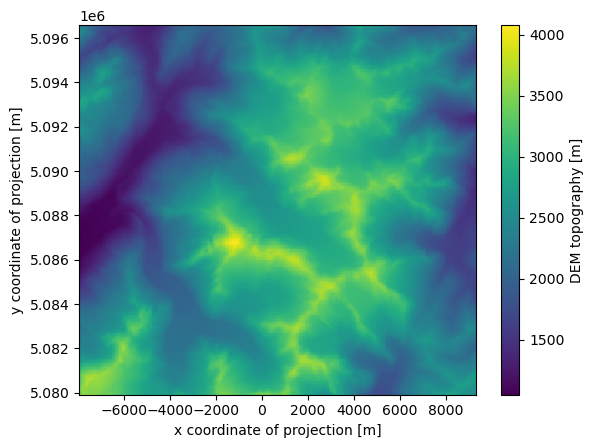

In [9]:
ds.topo.plot();

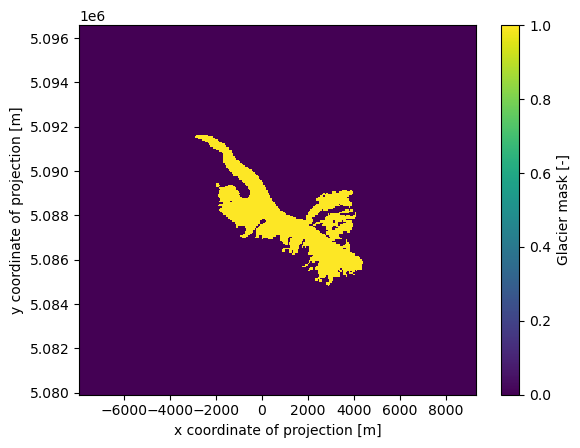

In [10]:
ds.glacier_mask.plot();

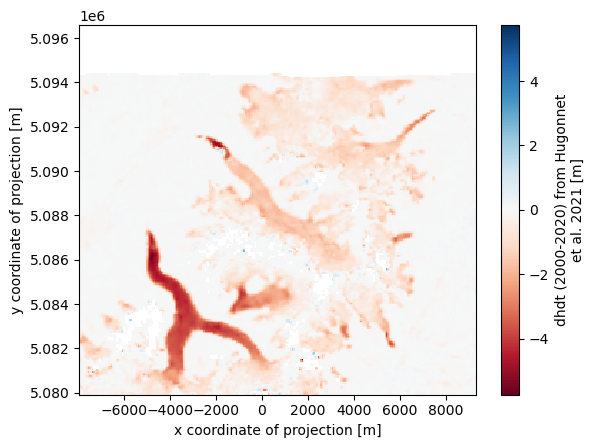

In [11]:
ds.hugonnet_dhdt.plot(cmap='RdBu');

Check this tutorial to plot more stuff: https://oggm.org/tutorials/stable/notebooks/10minutes/machine_learning.html

### Also works with climate data 

In [12]:
# Get the path to the climate data file
climate_data_path = gdir.get_filepath('climate_historical')

# Open it
with xr.open_dataset(climate_data_path) as ds_clim:
    ds_clim = ds_clim.load()
    
ds_clim

<xarray.Dataset>
Dimensions:   (time: 1428)
Coordinates:
  * time      (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2019-12-01
Data variables:
    prcp      (time) float32 94.16 8.007 85.21 135.3 ... 59.08 153.4 182.1 194.0
    temp      (time) float32 -5.958 -9.201 -4.13 0.8985 ... 9.9 6.6 0.3 -0.5
    temp_std  (time) float32 4.516 6.287 3.005 3.122 ... 2.742 1.807 3.548 2.588
Attributes:
    ref_hgt:         1940.0
    ref_pix_lon:     6.75
    ref_pix_lat:     45.75
    ref_pix_dis:     28823.67358258575
    climate_source:  GSWP3_W5E5
    yr_0:            1901
    yr_1:            2019
    author:          OGGM
    author_info:     Open Global Glacier Model

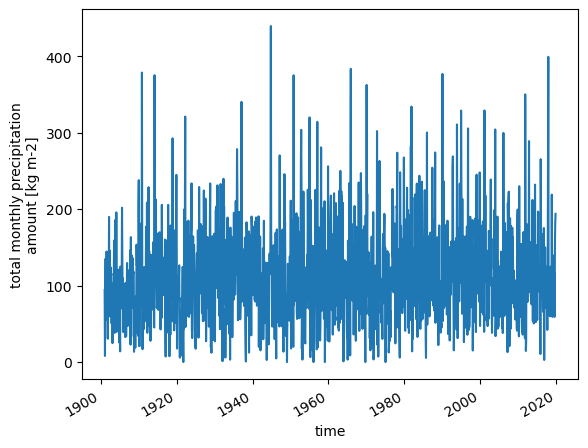

In [13]:
ds_clim.prcp.plot();

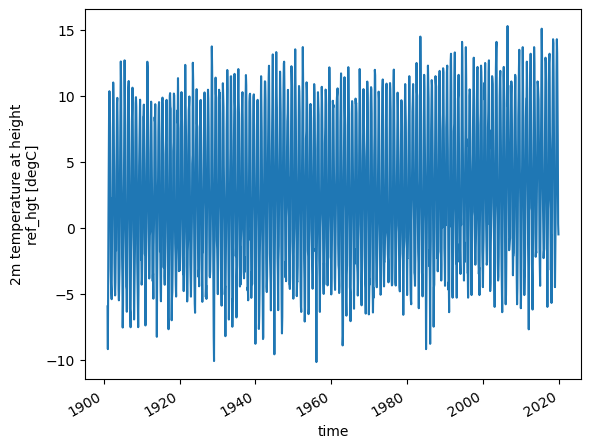

In [14]:
ds_clim.temp.plot();

## Create an OGGM task to add data to the glacier directory

See https://github.com/OGGM/oggm/blob/f305390e09a55c1fa204f4d7834c0e377f1c812f/oggm/shop/bedtopo.py#L22 for inspiration

Here we will just add a dummy mask to the file, to use it later:

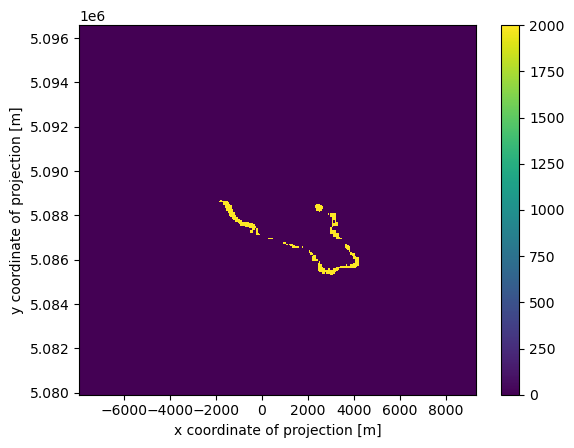

In [15]:
avalanches = ((ds.topo > 3000) & (ds.topo < 3100) & (ds.glacier_mask == 1)) * 2000
avalanches.plot();

In [16]:
# Add it to the dataset and write the file back to disk
ds['avalanches'] = avalanches
ds.to_netcdf(gridded_data_path)

## Obtain the avalanche data back to the flowlines 

We use OGGM for this. These are "binning" variables to 1D flowlines. 

Documentation:
- https://docs.oggm.org/en/stable/generated/oggm.tasks.elevation_band_flowline.html
- https://docs.oggm.org/en/stable/generated/oggm.tasks.fixed_dx_elevation_band_flowline.html

In [17]:
tasks.elevation_band_flowline(gdir, bin_variables=['avalanches', 'millan_v', 'hugonnet_dhdt'])
tasks.fixed_dx_elevation_band_flowline(gdir, bin_variables=['avalanches', 'millan_v', 'hugonnet_dhdt'], preserve_totals=True)

/mnt/c/Users/kneibm/Documents/OGGM/oggm/oggm/core/centerlines.py:2301: RuntimeWarning: Mean of empty slice
  df.loc[bi, var] = np.nanmean(data[bin_coords])


We just wrote a new file to disk. Let's open it:

In [18]:
binned_data_file = gdir.get_filepath('elevation_band_flowline', filesuffix='_fixed_dx')
binned_data = pd.read_csv(binned_data_file, index_col=0)
binned_data

,widths_m,area_m2,avalanches,millan_v,hugonnet_dhdt
dis_along_flowline,,,,,
62.0,316.752446,39277.303335,0.0,5.613090,NaN
186.0,1107.818442,137369.486763,0.0,12.174993,-0.227369
310.0,1643.800669,203831.282906,0.0,43.591102,-0.340548
434.0,1971.293271,244440.365580,0.0,22.143576,-0.291095
558.0,2629.341482,326038.343709,0.0,27.572208,-0.328318
...,...,...,...,...,...
7502.0,284.960968,35335.160073,0.0,48.790115,-2.177004
7626.0,319.152492,39574.908951,0.0,46.721052,-1.586653
7750.0,280.047055,34725.834834,0.0,26.808458,-0.337718


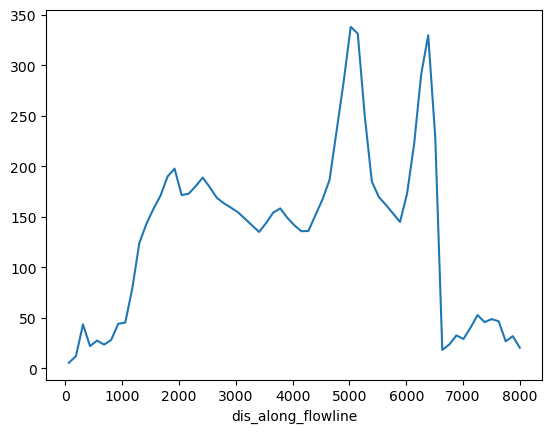

In [19]:
binned_data.millan_v.plot();

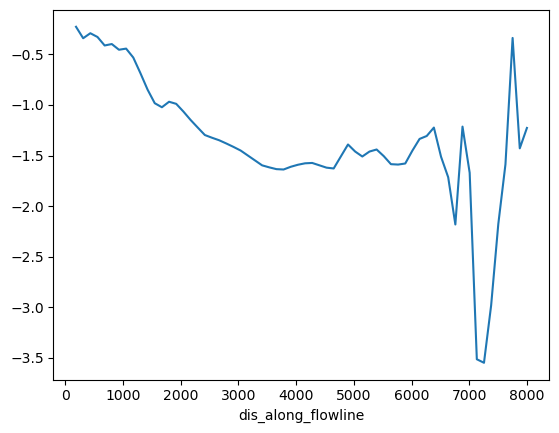

In [20]:
binned_data.hugonnet_dhdt.plot();

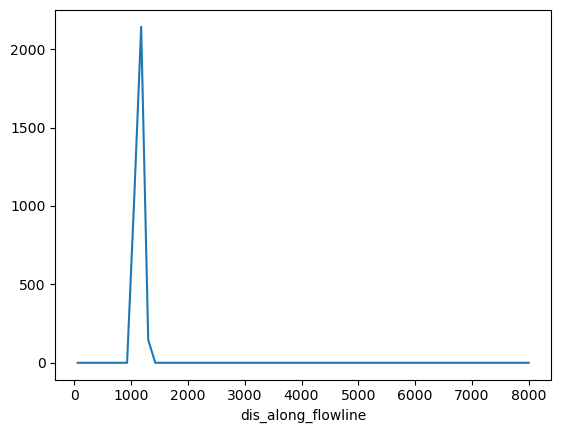

In [21]:
binned_data.avalanches.plot();

The "dis_along_flowline" variable is not consistent with what OGGM thinks of length (see bug report). This is not a big deal, the length of the data is still correct, so the below works.

In [22]:
# Note: glacier "length" according to RGI
gdir.read_shapefile('outlines')['Lmax'].iloc[0]

'9201'

## Use this information in the MB model 

This is a bit far stretched but lets go:

In [23]:
from oggm.core.massbalance import MonthlyTIModel

In [24]:
class AvalancheMassBalance(MonthlyTIModel):
    """We Inherit from the standard model, but will add some stuff to it"""

    def __init__(self, *args, **kwargs):
        """ """
        super(AvalancheMassBalance, self).__init__(*args, **kwargs)

    def get_annual_mb(self, heights, year=None, **kwargs):      
        # Here we get the default MB
        smb = super(AvalancheMassBalance, self).get_annual_mb(heights, year=year, **kwargs) 
        
        # Add avalanches
        where_is_avalanche = np.nonzero(binned_data.avalanches.values > 0)
        
        smb[where_is_avalanche] += binned_data.avalanches.values[where_is_avalanche] / cfg.SEC_IN_YEAR / self.rho
        
        # Return
        return smb 

Compare the two mb models:

In [25]:
flowline = gdir.read_pickle('inversion_flowlines')[0]

In [26]:
# Get model geometry
flowline = gdir.read_pickle('inversion_flowlines')[0]

# Create the MB models 
# This creates and average of the MB model over a certain period
mb_control = massbalance.MonthlyTIModel(gdir)
mb_ava = AvalancheMassBalance(gdir)

In [27]:
# Prepare the data
df_control = pd.DataFrame(index=flowline.dx_meter * np.arange(flowline.nx))
df_ava = pd.DataFrame(index=flowline.dx_meter * np.arange(flowline.nx))
for year in range(2000, 2020):
    df_control[year] = mb_control.get_annual_mb(flowline.surface_h, year=year) * cfg.SEC_IN_YEAR * mb_control.rho
    df_ava[year] = mb_ava.get_annual_mb(flowline.surface_h, year=year) * cfg.SEC_IN_YEAR * mb_control.rho

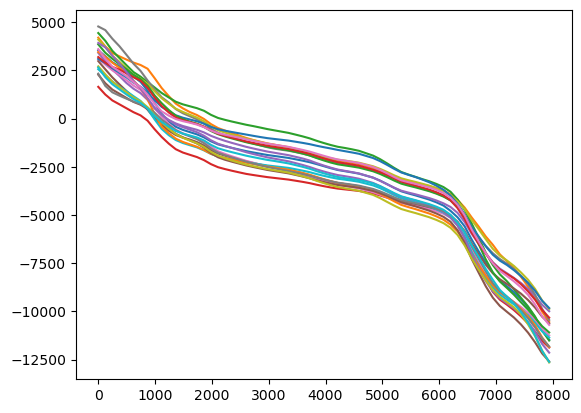

In [28]:
df_control.plot(legend=False);

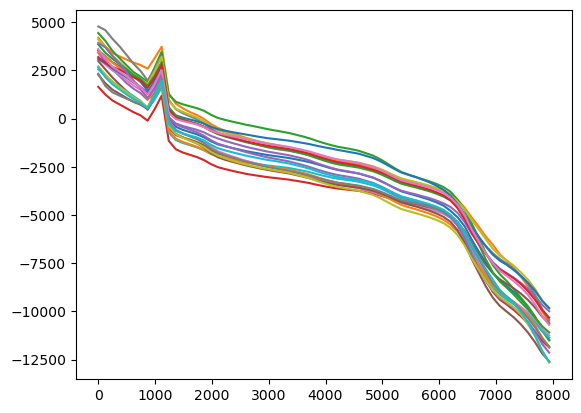

In [29]:
df_ava.plot(legend=False);

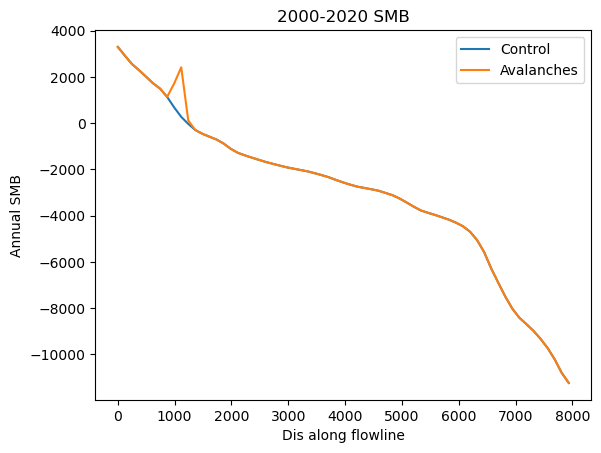

In [30]:
df_control.mean(axis=1).plot(label='Control');
df_ava.mean(axis=1).plot(label='Avalanches');
plt.legend(); plt.title('2000-2020 SMB'); plt.xlabel('Dis along flowline'); plt.ylabel('Annual SMB');

## Feed the models to the simulations 

In [31]:
cfg.PARAMS['store_fl_diagnostics'] = True

2024-01-18 17:01:41: oggm.cfg: PARAMS['store_fl_diagnostics'] changed from `False` to `True`.


In [32]:
tasks.run_random_climate(gdir, nyears=100, y0=2009, halfsize=10, seed=0,
                         mb_model_class=massbalance.MonthlyTIModel, 
                         output_filesuffix='_control');

In [33]:
tasks.run_random_climate(gdir, nyears=100, y0=2009, halfsize=10, seed=0,
                         mb_model_class=AvalancheMassBalance, 
                         output_filesuffix='_ava');

In [34]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_control')) as ds:
    ds_avg_control = ds.load()
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_ava')) as ds:
    ds_avg_ava = ds.load()

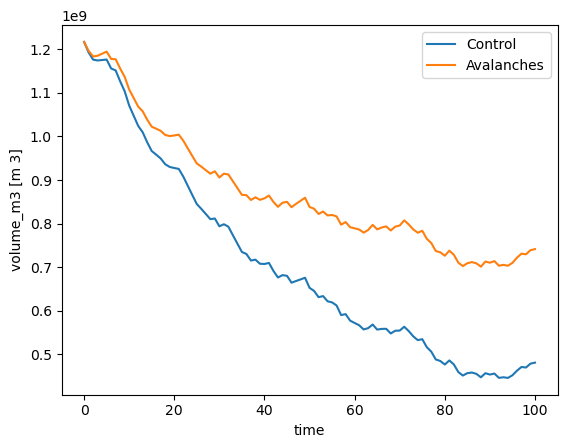

In [36]:
ds_avg_control.volume_m3.plot(label='Control');
ds_avg_ava.volume_m3.plot(label='Avalanches');
plt.legend();

In [37]:
with xr.open_dataset(gdir.get_filepath('fl_diagnostics', filesuffix='_control'), group='fl_0') as ds:
    ds_fl_control = ds.load()
with xr.open_dataset(gdir.get_filepath('fl_diagnostics', filesuffix='_ava'), group='fl_0') as ds:
    ds_fl_ava = ds.load()

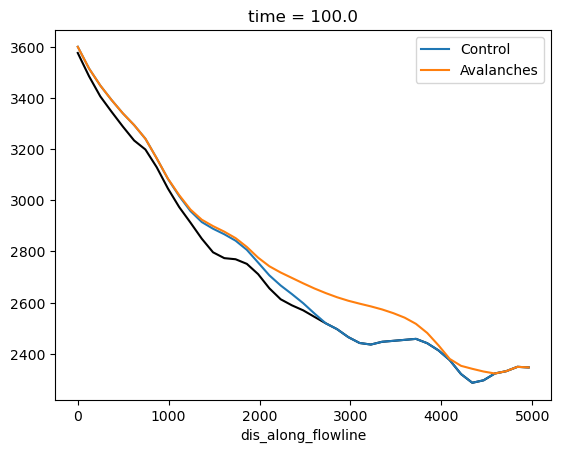

In [41]:
ds_sel_control = ds_fl_control.isel(time=-1).sel(dis_along_flowline=ds_fl_control.dis_along_flowline < 5000) 
ds_sel_ava = ds_fl_ava.isel(time=-1).sel(dis_along_flowline=ds_fl_ava.dis_along_flowline < 5000) 

ds_sel_control.bed_h.plot(color='k');
(ds_sel_control.bed_h + ds_sel_control.thickness_m).plot(label='Control');
(ds_sel_ava.bed_h + ds_sel_ava.thickness_m).plot(label='Avalanches');
plt.legend();

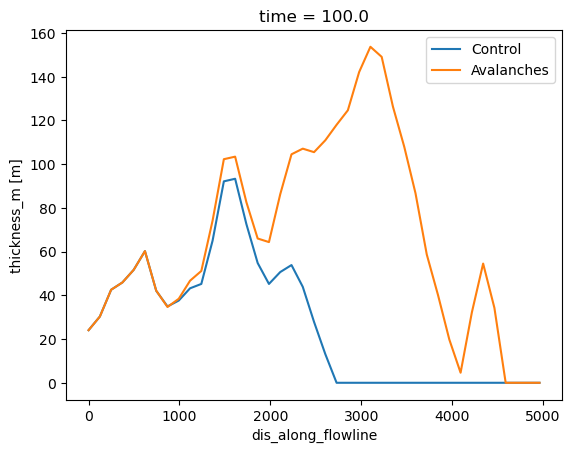

In [42]:
ds_sel_control.thickness_m.plot(label='Control');
ds_sel_ava.thickness_m.plot(label='Avalanches');
plt.legend();

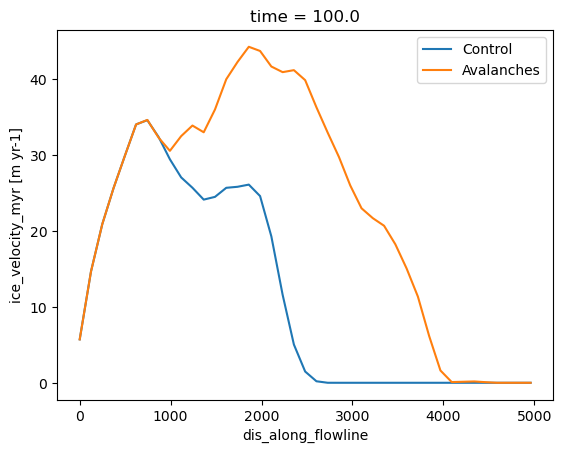

In [43]:
ds_sel_control.ice_velocity_myr.plot(label='Control');
ds_sel_ava.ice_velocity_myr.plot(label='Avalanches');
plt.legend();

## Things to think about 

- here we apply avalanching as a constant positive MB - in the future, will the avalanche amounts change?
- what about the time dependency?
- importantly, we apply the avalanches without recalibrating the MB. The purpose will be to actually recalibrate the MB with the new information
- on a glacier per glacier basis we will likely find that influence of avalanches will be small. But at the regional scale, in some regions in the himalayas, I think we can make a difference.
- lots to think about!